In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, UpSampling2D, Layer
from keras.models import Model,Sequential
from keras import backend as K
import numpy as np
import keras

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

##### Define the Sampling Layer

In [2]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

##### Variational Encoder

In [3]:
encoder_input = keras.layers.Input(
shape=(64, 64, 3), name="encoder_input")
x = keras.layers.Conv2D(32, (3, 3), strides=2, activation="relu",padding="same")(encoder_input)
x = keras.layers.Conv2D(64, (3, 3), strides=2, activation="relu",padding="same")(x)
x = keras.layers.Conv2D(128, (3, 3), strides=2, activation="relu",padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]
x = keras.layers.Flatten()(x)
z_mean = keras.layers.Dense(200, name="z_mean")(x)
z_log_var = keras.layers.Dense(200, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.models.Model(inputs=[encoder_input], outputs=[z_mean, z_log_var, z],name="encoder")


In [4]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 8, 8, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

##### Variational Decoder

In [5]:
decoder_input = keras.layers.Input(shape=(200,), name="decoder_input")
x = keras.layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = keras.layers.Reshape(shape_before_flattening)(x)
x = keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation = 'relu', padding="same")(x)
x = keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation = 'relu', padding="same")(x)
x = keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation = 'relu', padding="same")(x)
decoder_output = keras.layers.Conv2D(
3,
(3, 3),
strides = 1,
activation="sigmoid",
padding="same",
name="decoder_output"
)(x)
decoder = keras.models.Model(inputs=[decoder_input], outputs=[decoder_output])

In [6]:
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 8192)              1646592   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 64, 64, 32)        18464 

##### Full Variational AutoEncoder

In [7]:
_, _, codings = encoder(encoder_input)
reconstructions = decoder(codings)
variational_ae = tf.keras.Model(inputs=[encoder_input], outputs=[reconstructions])

In [8]:
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.exp(z_log_var) - tf.square(z_mean), axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss)/12288)

##### Load the Dataset and Preprocess

In [9]:
train_data = ImageDataGenerator(rescale=1./255)
test_data = ImageDataGenerator(rescale=1./255)

In [10]:
x_train = train_data.flow_from_directory('C:\\Users\\TeeFaith\\Desktop\\ML PROJECTS\\AUTO ENCODERS ON HUMAN DATASET\\Dataset\\Training\\',
                                         target_size=(64, 64),
                                         batch_size=10,
                                         class_mode='input')

Found 198 images belonging to 1 classes.


In [12]:
x_test = test_data.flow_from_directory('C:\\Users\\TeeFaith\\Desktop\\ML PROJECTS\\AUTO ENCODERS ON HUMAN DATASET\\Dataset\\Testing\\',
                                       target_size=(64, 64),
                                       batch_size=5,
                                       class_mode='input')

Found 44 images belonging to 1 classes.


In [14]:
variational_ae.compile(loss='mse', optimizer='nadam')

In [15]:
history = variational_ae.fit(
x_train,
epochs=100,
batch_size=10,
shuffle=True,
validation_data=x_test,
)

Epoch 1/100

20/20 [==============================] - 43s 592ms/step - loss: 0.1005 - val_loss: 0.0834
Epoch 2/100
20/20 [==============================] - 9s 441ms/step - loss: 0.0936 - val_loss: 0.0753
Epoch 3/100
20/20 [==============================] - 8s 418ms/step - loss: 0.0726 - val_loss: 0.0561
Epoch 4/100
20/20 [==============================] - 9s 475ms/step - loss: 0.0531 - val_loss: 0.0470
Epoch 5/100
20/20 [==============================] - 13s 665ms/step - loss: 0.0455 - val_loss: 0.0442
Epoch 6/100
20/20 [==============================] - 12s 599ms/step - loss: 0.0423 - val_loss: 0.0421
Epoch 7/100
20/20 [==============================] - 14s 701ms/step - loss: 0.0399 - val_loss: 0.0398
Epoch 8/100
20/20 [==============================] - 13s 651ms/step - loss: 0.0378 - val_loss: 0.0393
Epoch 9/100
20/20 [==============================] - 12s 622ms/step - loss: 0.0368 - val_loss: 0.0387
Epoch 10/100
20/20 [==============================] - 9s 451ms/step - loss: 0.0357 -

##### Generating new Images

1/1 [==============================] - 0s 169ms/step


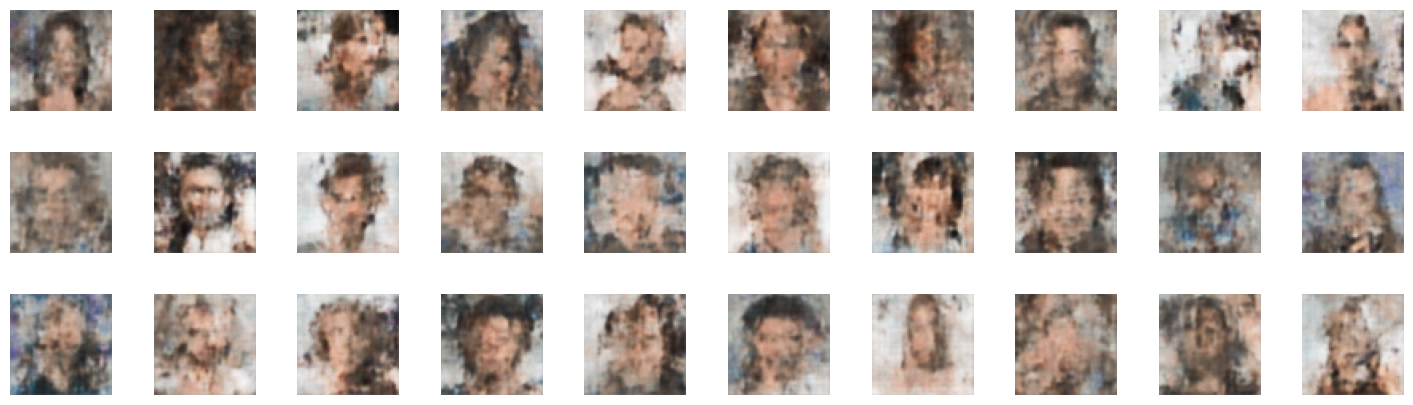

In [17]:
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 200))
recon = decoder.predict(z_sample)

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis('off')
    ax.imshow(recon[i, :, :])

##### Saving the models

In [18]:
encoder.save('Variational-Encoder.h5')

c:\Users\TeeFaith\anaconda3\envs\kenny\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
decoder.save('Variational-Decoder.h5')

In [20]:
variational_ae.save('Variatonal-AutoEncoder.h5')